In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Functions

In [67]:
'''
Load the data from the file and return a dataframe with the 
date, average temperature, and average temperature uncertainty.
'''
def load_data(filepath):
    df = (pd.read_csv(filepath)
          .dropna() # Remove rows with missing values
          .iloc[1:, :] # First row has a temp. but skips the sequence; that far back not useful
          .reset_index(drop=True)
          .rename(columns={"dt": "date", 
                           "AverageTemperature": "avg_temp", 
                           "AverageTemperatureUncertainty": "avg_temp_uncertainty", # May be interesting to plot avg. temp +/- uncertainty
                           }
          )
    )
    
    df['date'] = pd.to_datetime(df['date'])

    cols_sel = ['date', 'avg_temp', 'avg_temp_uncertainty']
    
    return df.loc[:, cols_sel]

'''
This function takes a dataframe and a date range and 
returns a slice of the dataframe that falls within the date range.
'''
def get_slice(df_inp, start_date, end_date):

    slice = df_inp[(df_inp["date"] >= start_date) & (df["date"] <= end_date)]

    return slice

'''
This function takes a dataframe and a list of years and returns a list of slices of the dataframe.
Each slice is a 3-year period starting from the year
'''
def get_slice_list(years, df_inp):
    slice_list = []
    for year in years:
        slice = get_slice(df_inp, f"{year}-01-01", f"{year+2}-12-31")
        slice_list.append(slice)
    return slice_list

'''
Take a dataframe slice and size for training set and return the train and test sets.
Temporal so takes the first train_size rows as the training set and the rest as the test set.
'''
def train_test_split(df_slice_inp, train_size):
    train = (df_slice_inp.iloc[:train_size, :]["avg_temp"]
             .to_numpy()
             .reshape(-1, 1)
             )
    test = (df_slice_inp.iloc[train_size:, :]["avg_temp"]
            .to_numpy()
            .reshape(-1, 1)
    )

    return train, test

'''
Take a list of dataframe slices and a size for the training set and return the train and test sets.
X_train will be a 3D array with dimensions (num_slices, train_size, 1)
y_train will be a 3D array with dimensions (num_slices, (slice_size - train_size), 1)
'''
def train_test_split_batches(df_slice_lst, train_size):
    X_lst = []
    y_lst = []

    for df_slice in df_slice_lst:
        X, y = train_test_split(df_slice, train_size)
        X_lst.append(X)
        y_lst.append(y)

    X_train = np.array(X_lst)
    y_train = np.array(y_lst)

    return X_train, y_train

'''
Returns a dictionary for a simple RNN model with the following layers:
    - InputLayer
    - FullyConnectedLayer (FCLU, weights size D x K)
    - TanhLayer
    - FullyConnectedLayer (FCLW, weights size K x K) - for feedback 
    - FullyConnectedLayer (FCLV, weights size K x output_size) - for output
        * Must be reshaped to dimensions of labels to calculate errors
    - LinearLayer
    - SquaredError

'''
def make_RNN(X_inp, fcl_size, output_size, act_func="tanh"):

    from Layers.InputLayer import InputLayer
    from Layers.FullyConnectedLayer import FullyConnectedLayer
    from Layers.TanhLayer import TanhLayer
    from Layers.ReLULayer import ReLULayer
    from Layers.LinearLayer import LinearLayer
    from LossFunctions.SquaredError import SquaredError

    IL = InputLayer(X_inp)
    FCLU = FullyConnectedLayer(X_inp.shape[1], fcl_size, random=False, randstate=0)
    if act_func == "relu":
        ACT1 = ReLULayer()
    else:
        ACT1 = TanhLayer()

    FCLW = FullyConnectedLayer(fcl_size, fcl_size, random=False, randstate=1)
    FCLV = FullyConnectedLayer(fcl_size, output_size, random=False, randstate=2)
    ACT2 = LinearLayer()
    SE = SquaredError()

    model = {"IL": IL, "FCLU": FCLU, "ACT1": ACT1, "FCLW": FCLW, "FCLV": FCLV, "ACT2": ACT2, "SE": SE}

    return model

'''
Save the model to a pickle file.
Automatically puts in a subdirectory called "Models"
'''
def save_model_pickle(model, filename):
    import pickle

    with open(f"./Models/{filename}", "wb") as f:
        pickle.dump(model, f)

'''
Load the model from a pickle given filepath
'''
def load_model_pickle(filepath):
    import pickle

    with open(filepath, "rb") as f:
        model = pickle.load(f)

    return model

# Load and split data

In [57]:
df = load_data("./Data/PhiladelphiaLandTemperatures.csv")
years_train = [1980, 1983, 1990, 1993, 2000, 2003]

slices_train = get_slice_list(years_train, df)

X_train, y_train = train_test_split_batches(slices_train, 24)

# Train RNN

## `train_RNN_inplace_with_batches_for()`

In [32]:
def train_RNN_inplace_with_batches_for(model, X, y, learning_rate, epochs):

    training_dict = {"epoch": list(range(epochs)),
                     "squared_error_avg": [],
                    #  "y_preds": [],
                     }

    for epoch in range(epochs):
        error_batches = []
        y_preds_batches = []
        for batch in range(len(X)):
            # Forward
            for t in range(len(X[batch])):
                IL_out = model["IL"].forward(X[batch][t])
                if t > 0:
                    FCLU_out = model["FCLU"].forward_with_feedback(IL_out, model["FCLW"].getPrevOut()[t-1])
                else:
                    FCLU_out = model["FCLU"].forward(IL_out)
                ACT1_out = model["ACT1"].forward(FCLU_out)
                FCLW_out = model["FCLW"].forward(ACT1_out)
                FCLV_out = model["FCLV"].forward(ACT1_out)
                ACT2_out = model["ACT2"].forward(FCLV_out)

            # Predictions and Loss
            y_preds_batch = ACT2_out
            y_preds_batches.append(y_preds_batch)
            # training_dict["y_preds"].append(ACT2_out)

            error_batch = model["SE"].eval(y, ACT2_out.reshape(y[batch].shape))
            # training_dict["squared_error"].append(error_batch)
            error_batches.append(error_batch)

            # Backward
            dhNext_dW = np.zeros((1, model["FCLV"].getWeights().shape[0])) # Same shape as what FCLV.backward(grad) is...
            
            for t in range(len(X[batch])-1, -1, -1):
                grad = model["SE"].gradient(y[batch], (model["ACT2"].getPrevOut()[-1].reshape(y[batch].shape))).reshape(1, -1)
                grad = model["ACT2"].backward(grad, t_inp=t)

                model["FCLV"].updateWeightsGradAccum(grad, t_inp=t)
                model["FCLV"].updateBiasesGradAccum(grad)

                grad = model["FCLV"].backward(grad) + dhNext_dW
                # if t == len(X)-1:
                    # print(f"FCLV gradient shape is: {grad.shape}") # Verify gradient shape
                grad = model["ACT1"].backward(grad, t_inp=t)

                if t > 0:
                    model["FCLW"].updateWeightsGradAccum(grad, t_inp=t-1) # Have to use t-1
                    model["FCLW"].updateBiasesGradAccum(grad)

                model["FCLU"].updateWeightsGradAccum(grad, t_inp=t)
                model["FCLU"].updateBiasesGradAccum(grad)

                dhNext_dW = model["FCLW"].backward(grad)

            # Update weights   
            model["FCLU"].updateWeights(grad, eta=learning_rate)
            model["FCLV"].updateWeights(grad, eta=learning_rate)
            model["FCLW"].updateWeights(grad, eta=learning_rate)
        training_dict["squared_error_avg"].append(np.mean(error_batches))

    return pd.DataFrame(training_dict)

## Error vs. Epochs

In [44]:
lr = 1e-6

# Assume scaling by X_train[0] is sufficient for all batches
rnn_tanh_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0]) # Have to reinitialize
training_results_tanh_batches = train_RNN_inplace_with_batches_for(rnn_tanh_batches, X_train, y_train, learning_rate=lr, epochs=60)
training_results_tanh_batches

,epoch,squared_error_avg
0,0,229.559644
1,1,228.779908
2,2,227.220561
3,3,224.892374
4,4,221.811432
5,5,217.999017
6,6,213.481466
7,7,208.289985
8,8,202.460438
9,9,196.033093


<AxesSubplot: xlabel='epoch'>

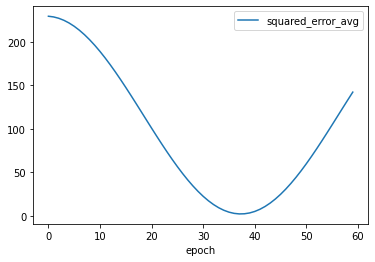

In [41]:
pd.DataFrame(training_results_tanh_batches).plot(x="epoch", y="squared_error_avg")

## Optimal: lr = 1e-6, epochs = 37

<AxesSubplot: xlabel='epoch'>

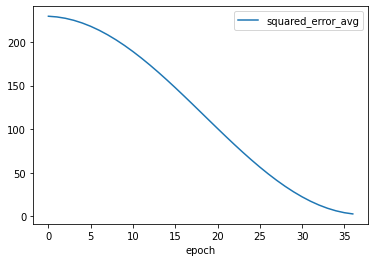

In [82]:
lr = 1e-6

# Assume scaling by X_train[0] is sufficient for all batches
rnn_tanh_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0]) # Have to reinitialize
training_results_tanh_batches = train_RNN_inplace_with_batches_for(rnn_tanh_batches, X_train, y_train, learning_rate=lr, epochs=37)

pd.DataFrame(training_results_tanh_batches).plot(x="epoch", y="squared_error_avg")

In [84]:
pd.DataFrame(training_results_tanh_batches).tail(5)

,epoch,squared_error_avg
32,32,13.031355
33,33,9.362835
34,34,6.430530
35,35,4.254709
36,36,2.850419


# Plot Training predictions of batches, examine individual RMSEs

In [53]:
rnn_tanh_batches

{'IL': <Layers.InputLayer.InputLayer at 0x7f2c3357c940>,
 'FCLU': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7f2c31075100>,
 'ACT1': <Layers.TanhLayer.TanhLayer at 0x7f2c310751c0>,
 'FCLW': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7f2c310752b0>,
 'FCLV': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7f2c31075640>,
 'ACT2': <Layers.LinearLayer.LinearLayer at 0x7f2c31075670>,
 'SE': <LossFunctions.SquaredError.SquaredError at 0x7f2c310754f0>}

### `predict_batches()`

In [96]:
def predict_batches(model, X_inp, y_inp):
    rmse_batches = []
    y_preds_batches = []
    for batch in range(len(X_inp)):
        for t in range(len(X_inp[batch])):
            IL_out = model["IL"].forward(X_inp[batch][t])
            if t > 0:
                FCLU_out = model["FCLU"].forward_with_feedback(IL_out, model["FCLW"].getPrevOut()[t-1])
            else:
                FCLU_out = model["FCLU"].forward(IL_out)
            ACT1_out = model["ACT1"].forward(FCLU_out)
            FCLW_out = model["FCLW"].forward(ACT1_out)
            FCLV_out = model["FCLV"].forward(ACT1_out)
            ACT2_out = model["ACT2"].forward(FCLV_out)



        y_pred_batch = ACT2_out
        # print(y_pred_batch) # Print output
        y_preds_batches.append(y_pred_batch)

        error_batch = model["SE"].eval(y_inp[batch], y_pred_batch.reshape(y_inp[batch].shape))
        rmse_batch = np.sqrt(error_batch)
        rmse_batches.append(rmse_batch)

    return y_preds_batches, rmse_batches

In [49]:
y_preds_train, rmses_train = predict_batches(rnn_tanh_batches, X_train, y_train)

RMSE for 1980 is: 1.73
RMSE for 1983 is: 1.56
RMSE for 1990 is: 0.93
RMSE for 1993 is: 1.65
RMSE for 2000 is: 1.76
RMSE for 2003 is: 1.42


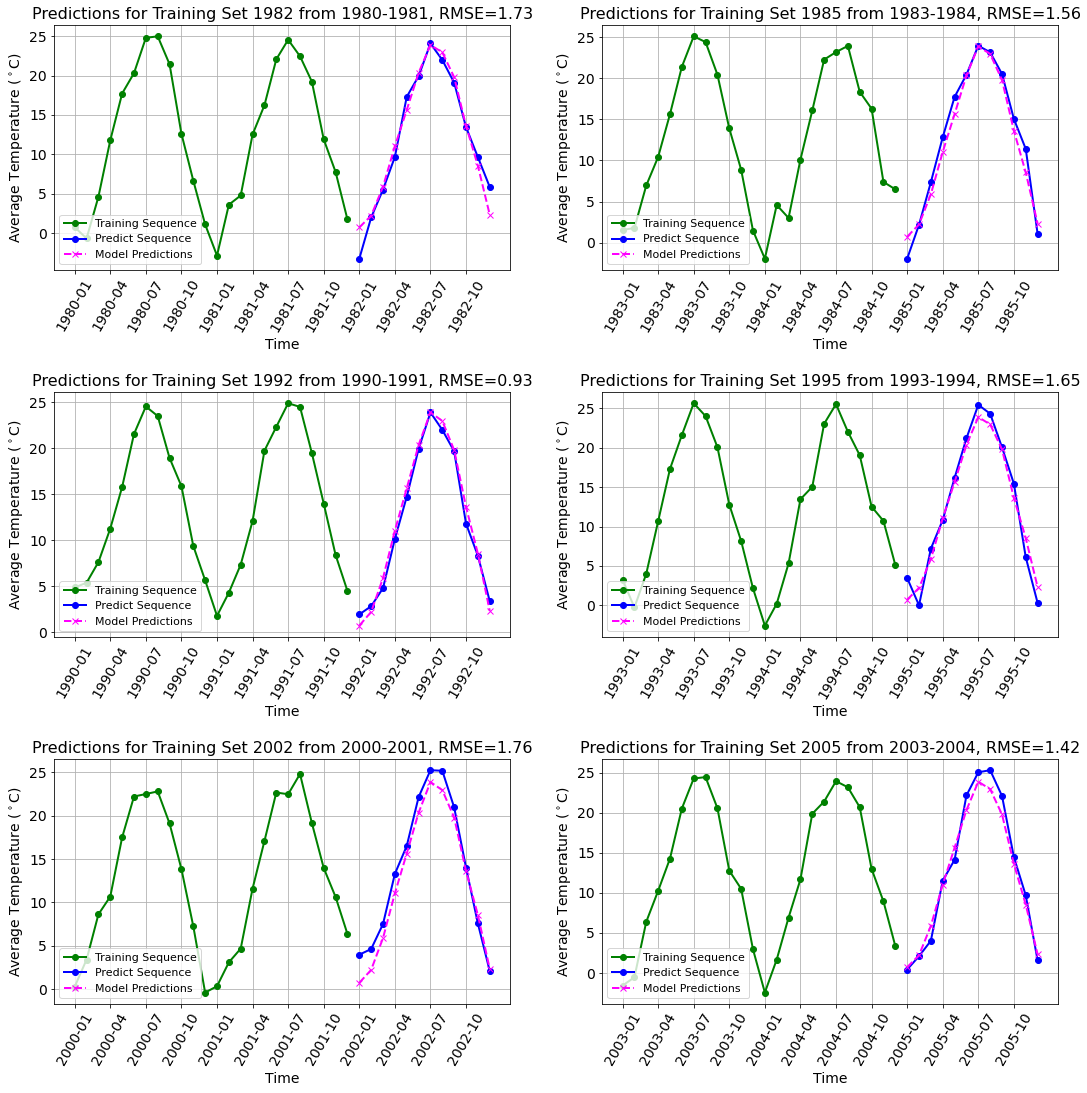

In [91]:
ax_coords = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

fig, axs = plt.subplots(3, 2, figsize=(18, 18), facecolor="white")
for i in range(len(years_train)):
    year = years_train[i]
    train_slice = slices_train[i]
    X_batch = X_train[i]
    y_batch = y_train[i]
    ax_coord = ax_coords[i]
    y_pred_batch = y_preds_train[i]
    rmse_batch = rmses_train[i]

    t_vals_x = train_slice.iloc[:len(X_batch), :]["date"].dt.strftime('%Y-%m')
    t_vals_y = train_slice.iloc[len(X_batch):(len(X_batch)+len(y_batch)), :]["date"].dt.strftime('%Y-%m')

    axs[ax_coord].plot(t_vals_x, X_batch.flatten(), color="green", linestyle="solid", label="Training Sequence", linewidth=2, marker="o")
    axs[ax_coord].plot(t_vals_y, y_batch.flatten(), color="blue", linestyle="solid", label="Predict Sequence", linewidth=2, marker="o")


    axs[ax_coord].plot(t_vals_y, y_pred_batch.flatten(), color = "magenta", linestyle="dashed", label=f"Model Predictions", linewidth=2, marker="x")


    axs[ax_coord].set_xlabel("Time", fontsize=14)
    axs[ax_coord].set_ylabel("Average Temperature ($^\circ$C)", fontsize=14)
    axs[ax_coord].set_title(f"Predictions for Training Set {year+2} from {year}-{year+1}, RMSE={rmse_batch:.2f}", 
                fontsize=16)
    new_xticks = (train_slice["date"].dt.strftime('%Y-%m')
                  .iloc[list(range(0, len(train_slice), 3))] # 3 month intervals
    )
    axs[ax_coord].set_xticks(new_xticks, labels=new_xticks.astype(str), rotation=60)
    # axs[ax_coord].set_xticks(new_xticks, rotation=45)
    # axs[ax_coord].set_xticklabels(new_xticks, rotation=45)
    axs[ax_coord].tick_params(axis="x", labelsize=14)
    axs[ax_coord].tick_params(axis="y", labelsize=14)
    axs[ax_coord].legend(fontsize=11, loc="lower left")
    axs[ax_coord].grid()

    # val_testing_dict["rmse"].append(rmse_batch)

    print(f"RMSE for {year} is: {rmse_batch:.2f}")
plt.subplots_adjust(hspace=0.5)

## Predictions nearly the same across training batches

In [66]:
y_preds_train

[array([[ 0.72543652,  2.2173868 ,  5.8917181 , 11.03795877, 15.63022407,
         20.33218363, 23.87757496, 22.9444464 , 19.78307613, 13.62107675,
          8.53994549,  2.3261231 ]]),
 array([[ 0.72543653,  2.21738681,  5.89171812, 11.0379588 , 15.63022412,
         20.33218367, 23.87757502, 22.94444645, 19.78307618, 13.62107678,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.21738681,  5.89171811, 11.03795878, 15.6302241 ,
         20.33218365, 23.877575  , 22.94444643, 19.78307616, 13.62107677,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.21738681,  5.89171811, 11.03795879, 15.63022411,
         20.33218366, 23.877575  , 22.94444644, 19.78307616, 13.62107677,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.21738681,  5.89171812, 11.03795879, 15.63022412,
         20.33218367, 23.87757502, 22.94444645, 19.78307618, 13.62107678,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.2173868 ,  5.89171811, 11.03795878, 15.630224

### Save model

In [69]:
save_model_pickle(rnn_tanh_batches, "rnn_tanh_batches_6batches.pkl")

# Check validation

In [94]:
years_val = [1986, 1996, 2006,]

slices_val = get_slice_list(years_val, df)

X_val, y_val = train_test_split_batches(slices_train, 24)

In [97]:
y_preds_val, rmses_val = predict_batches(rnn_tanh_batches, X_val, y_val)
y_preds_val

[array([[ 0.72543652,  2.2173868 ,  5.8917181 , 11.03795877, 15.63022407,
         20.33218363, 23.87757496, 22.9444464 , 19.78307613, 13.62107675,
          8.53994549,  2.3261231 ]]),
 array([[ 0.72543653,  2.21738681,  5.89171812, 11.0379588 , 15.63022412,
         20.33218367, 23.87757502, 22.94444645, 19.78307618, 13.62107678,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.21738681,  5.89171811, 11.03795878, 15.6302241 ,
         20.33218365, 23.877575  , 22.94444643, 19.78307616, 13.62107677,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.21738681,  5.89171811, 11.03795879, 15.63022411,
         20.33218366, 23.877575  , 22.94444644, 19.78307616, 13.62107677,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.21738681,  5.89171812, 11.03795879, 15.63022412,
         20.33218367, 23.87757502, 22.94444645, 19.78307618, 13.62107678,
          8.53994549,  2.32612311]]),
 array([[ 0.72543653,  2.2173868 ,  5.89171811, 11.03795878, 15.630224

In [99]:
rmses_val

[1.7301142994236802,
 1.5621254880048299,
 0.9287634292797382,
 1.6506569713441517,
 1.7638756607341126,
 1.4236958945972977]

In [100]:
np.mean(rmses_val)

1.509871957230635

In [101]:
np.std(rmses_val)

0.2830455962660777

# Train RNN with early stopping

In [88]:
lr = 1e-6

# Assume scaling by X_train[0] is sufficient for all batches
rnn_tanh_batches_early_stop = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0]) # Have to reinitialize
training_results_tanh_batches_early_stop = train_RNN_inplace_with_batches_for(rnn_tanh_batches_early_stop, X_train, y_train, learning_rate=lr, epochs=33)
training_results_tanh_batches_early_stop.tail(5)

,epoch,squared_error_avg
28,28,34.488065
29,29,28.176283
30,30,22.470696
31,31,17.410731
32,32,13.031355


## Predictions also the same for each input

In [89]:
y_preds_train_early_stop, rmses_train_early_stop = predict_batches(rnn_tanh_batches_early_stop, X_train, y_train)
y_preds_train_early_stop

[array([[ 0.59880565,  1.83994973,  4.89039689,  9.16028827, 12.97430528,
         16.87375951, 19.81699123, 19.04120211, 16.41809142, 11.30470593,
          7.08913607,  1.93250304]]),
 array([[ 0.59880566,  1.83994974,  4.8903969 ,  9.1602883 , 12.97430532,
         16.87375954, 19.81699128, 19.04120214, 16.41809146, 11.30470596,
          7.08913607,  1.93250305]]),
 array([[ 0.59880566,  1.83994973,  4.8903969 ,  9.16028829, 12.97430531,
         16.87375953, 19.81699126, 19.04120213, 16.41809144, 11.30470595,
          7.08913607,  1.93250305]]),
 array([[ 0.59880566,  1.83994973,  4.8903969 ,  9.16028829, 12.97430531,
         16.87375953, 19.81699126, 19.04120213, 16.41809145, 11.30470595,
          7.08913607,  1.93250305]]),
 array([[ 0.59880566,  1.83994973,  4.8903969 ,  9.16028829, 12.97430532,
         16.87375954, 19.81699128, 19.04120214, 16.41809146, 11.30470596,
          7.08913607,  1.93250305]]),
 array([[ 0.59880566,  1.83994973,  4.8903969 ,  9.16028828, 12.974305